Model is from: https://www.kaggle.com/bulentsiyah/dogs-vs-cats-classification-vgg16-fine-tuning


# Download Dataset

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json, fetched from Kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ryannki","key":"4504bee452ef3ff1e1365c61c3937caf"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# !mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c dogs-vs-cats

### Unzipping Dataset
import zipfile

with zipfile.ZipFile("train.zip","r") as z:
    z.extractall(".")

with zipfile.ZipFile("test1.zip","r") as z:
    z.extractall(".")

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          17831  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10629  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5278  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3823  
promptcloud/car

# Import Library

In [ ]:
!pip install keras

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os


# Prepare Traning Data

In [ ]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.4879.jpg,0
1,dog.8900.jpg,1
2,cat.6173.jpg,0
3,cat.5302.jpg,0
4,dog.10564.jpg,1


### See Total In count

1    12500
0    12500
Name: category, dtype: int64


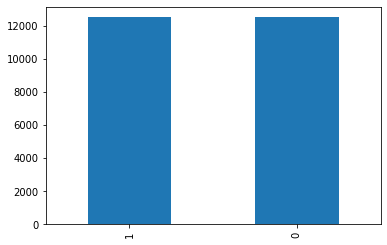

In [ ]:
df['category'].value_counts().plot.bar()
print(df['category'].value_counts())

# See sample image

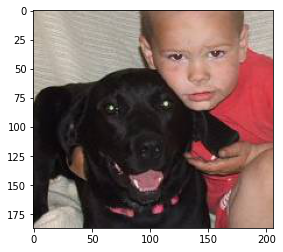

In [ ]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

# Build Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras import applications
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

print(last_output)
    
c_ratio = 0.003 # MEC compress ratio
nn_size = 512
nn_size = int(nn_size*c_ratio)
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(nn_size, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

mec = 7*7*512*nn_size + nn_size*2 + 1
print("MEC: ", mec)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
MEC:  25091
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Prepare Test and Train Data

20250 2250 2500
1    2562
0    2500
Name: category, dtype: int64
5062 562


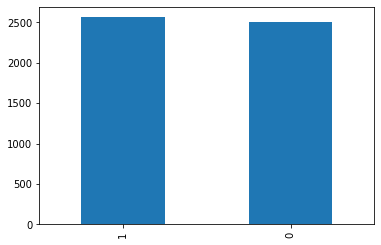

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1)
train_df, validate_df = train_test_split(train_df, test_size = 0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()
test_df = test_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
total_test = test_df.shape[0]

print(total_train, total_validate, total_test)

ratio = 0.25
train_df = train_df[: int(total_train * ratio)]
validate_df = validate_df[: int(total_validate * ratio)]

train_df['category'].value_counts().plot.bar()
print(train_df['category'].value_counts())

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print(total_train, total_validate)

# Traning Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    # class_mode='binary',
    class_mode='raw',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 5062 validated image filenames.


# Validation Generator

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    # class_mode='binary',
    class_mode='raw',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 562 validated image filenames.


# Test Generator

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = validation_datagen.flow_from_dataframe(
    test_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    # class_mode='binary',
    class_mode='raw',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames.


# See sample generated images

Found 1 validated image filenames.


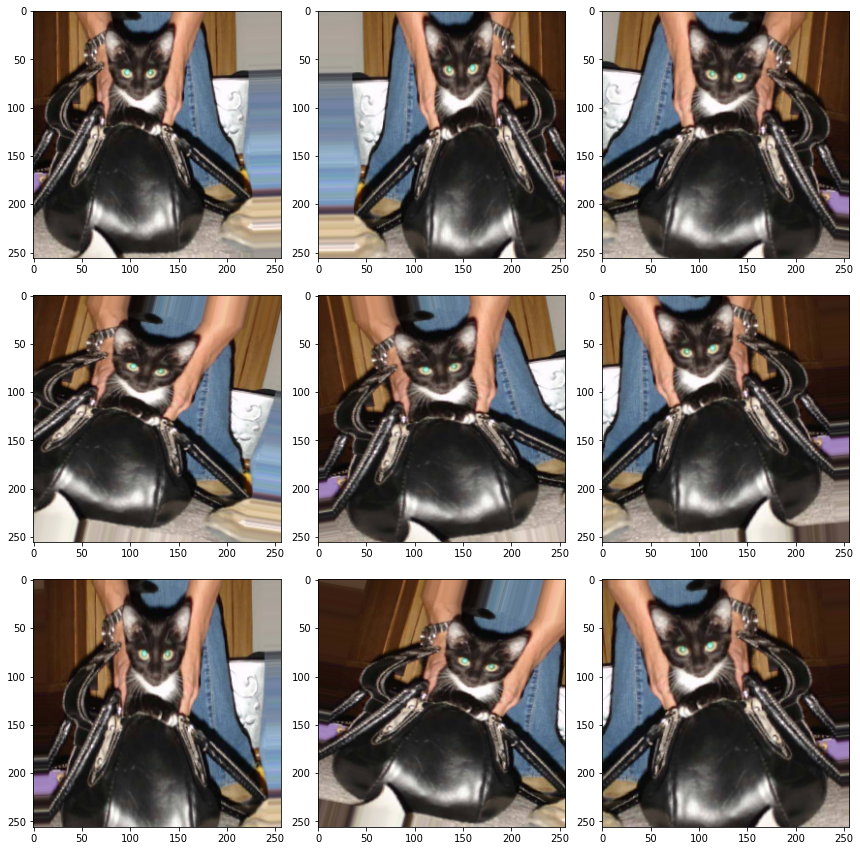

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    # class_mode='binary',
    class_mode='raw'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [ ]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/5
316/316 [==============================] - 93s 292ms/step - loss: 0.6841 - accuracy: 0.5250 - val_loss: 0.6395 - val_accuracy: 0.6518
Epoch 2/5
316/316 [==============================] - 92s 290ms/step - loss: 0.6245 - accuracy: 0.6274 - val_loss: 0.5533 - val_accuracy: 0.8518
Epoch 3/5
316/316 [==============================] - 92s 290ms/step - loss: 0.5911 - accuracy: 0.6702 - val_loss: 0.5025 - val_accuracy: 0.8768
Epoch 4/5
316/316 [==============================] - 92s 290ms/step - loss: 0.5814 - accuracy: 0.6792 - val_loss: 0.4906 - val_accuracy: 0.9071
Epoch 5/5
316/316 [==============================] - 92s 289ms/step - loss: 0.5677 - accuracy: 0.6988 - val_loss: 0.4574 - val_accuracy: 0.9054


In [ ]:
loss, accuracy = model.evaluate_generator(test_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test: accuracy = 0.892857  ;  loss = 0.451125 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


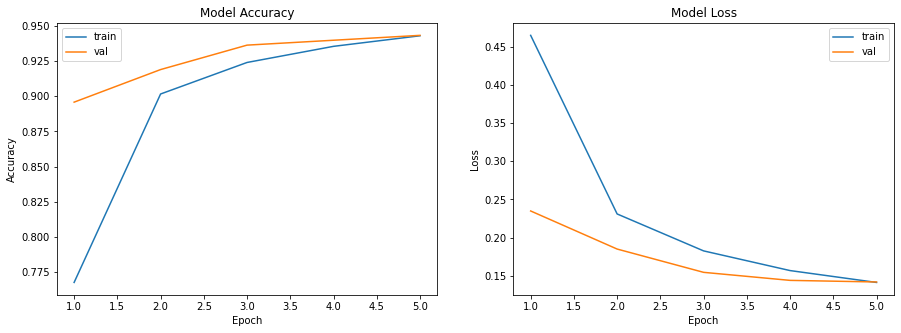

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [ ]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [ ]:
y_final.size

875

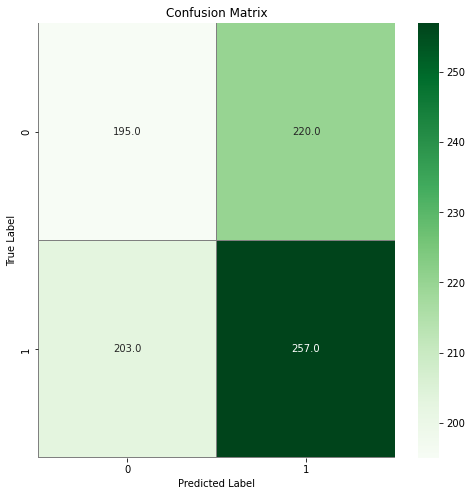

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.49      0.47      0.48       415
           1       0.54      0.56      0.55       460

    accuracy                           0.52       875
   macro avg       0.51      0.51      0.51       875
weighted avg       0.52      0.52      0.52       875



# Prepare Testing Data

In [ ]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


# Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


# See predicted result

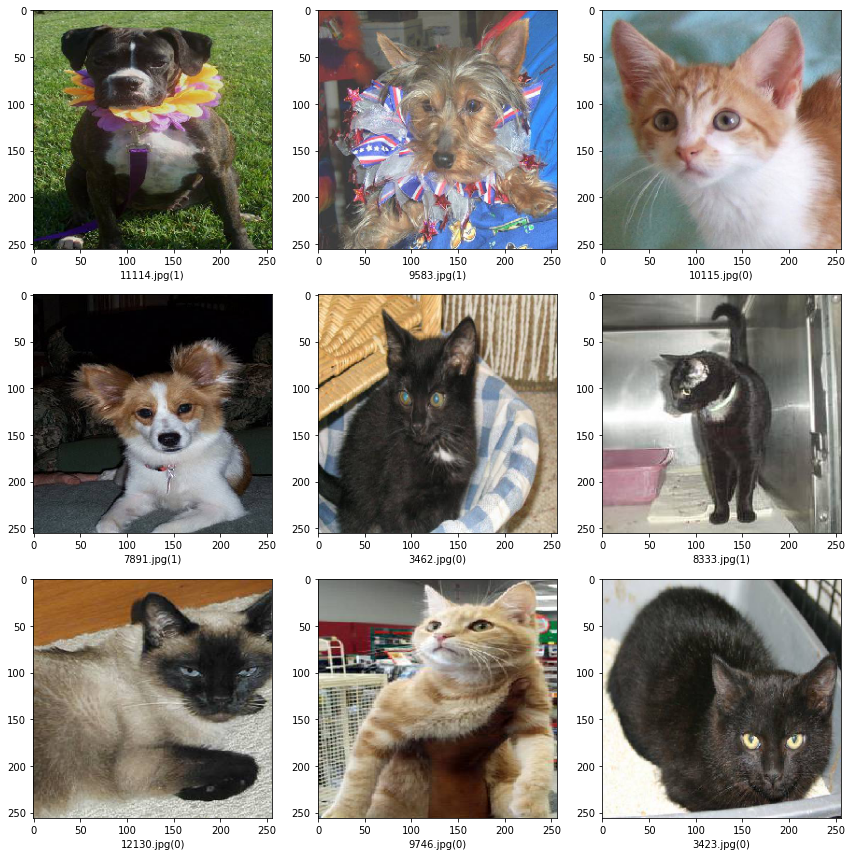

In [ ]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

# Submission

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data)')

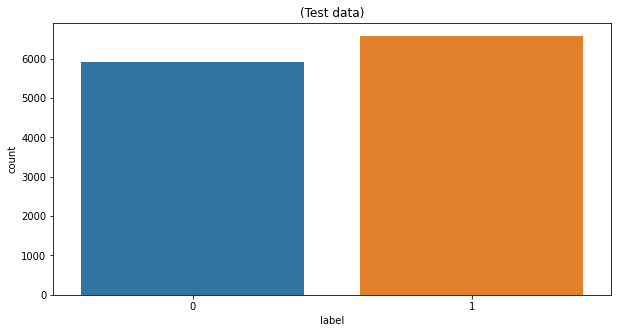

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")